In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [176]:
pd.__version__

'0.16.2'

In [177]:
sns.set_palette("deep") # deep, muted, pastel, bright, dark, and colorblind

In [178]:
df = pd.read_csv('titanic_data.csv')

In [179]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


* 891 records
* Cabin has most missing values
* Age is missing to
* Embarked is missing from 2 records

## Estimating missing Embarked

In [180]:
# frequency count by Embarked
df.Embarked.value_counts(normalize=True).rename({'C':'Cherbourg', 'Q':'Queenstown', 'S':'Southampton'})

Southampton    0.722783
Cherbourg      0.188552
Queenstown     0.086420
dtype: float64

In [181]:
# What are missing Embarked records ?
df[df.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,NaN


In [182]:
pclass1_by_embarked = df.loc[df.Pclass==1].groupby('Embarked')
pclass1_by_embarked['Fare'].describe(percentiles=[.25,.5,.75,.95]).unstack()

,count,mean,std,min,25%,50%,75%,95%,max
Embarked,,,,,,,,,
C,85,104.718529,99.093935,26.55,49.50,78.2667,110.8833,259.40416,512.3292
Q,2,90.000000,0.000000,90.00,90.00,90.0000,90.0000,90.00000,90.0000
S,127,70.364862,58.811278,0.00,29.25,52.0000,83.4750,211.33750,263.0000


75% fare is under ~83 for embarked S with mean of ~70. We could assume that missing Embarked records are from S.

In [183]:
# Populate the missing Embarked
df.loc[df.Embarked.isnull(),'Embarked'] = 'S'

## Families survive together
Inspired by <https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic>

In [184]:
# Create new column FamilySize
# FamilySize = SibSp + Parch + 1
#            = Number of Siblings/Spouses Aboard 
#              + Number of Parents/Children Aboard
#              + Themselves
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['FamilySize'].describe(percentiles=[.25,.5,.75,.95])

count    891.000000
mean       1.904602
std        1.613459
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
95%        6.000000
max       11.000000
Name: FamilySize, dtype: float64

Most have (75%) have family of 2 or less. 

#### Survival by FamilySize

In [185]:
d = pd.crosstab(df.FamilySize,df.Survived)
d.columns = ['Dead','Survived']
d['Total'] = d['Dead'] + d['Survived']
d['%Survived'] = (d['Survived']/d['Total']).round(2);d

,Dead,Survived,Total,%Survived
FamilySize,,,,
1,374,163,537,0.30
2,72,89,161,0.55
3,43,59,102,0.58
4,8,21,29,0.72
5,12,3,15,0.20
6,19,3,22,0.14
7,8,4,12,0.33
8,6,0,6,0.00
11,7,0,7,0.00


Family size of 2 to 4 tends to survive more.

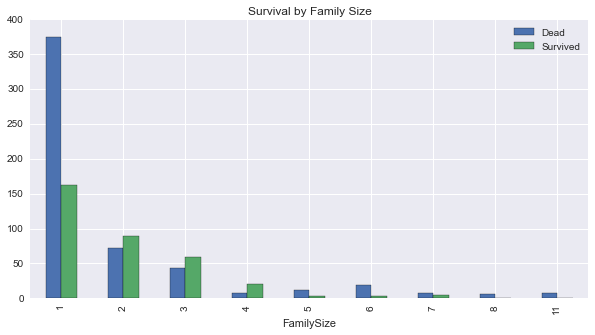

In [186]:
d[['Dead','Survived']].plot(kind='bar',figsize=(10,5),title='Survival by Family Size')

Family size of 2 to 4 survived more than rest. Singles and large (`>4`) families had less chances of survival.

We can make it more clear by making a category variable, that separates data based on family size.
* **Singleton**
        Family Size == 1
* **Small**
        1 < Family Size <= 4
* **Large**
        Family Size > 4

In [187]:
df['FamilySizeD'] = pd.cut(df.FamilySize, [0,1,4,df.FamilySize.max()+1], labels=["Singleton","Small","Large"])
df.FamilySizeD.value_counts()

Singleton    537
Small        292
Large         62
dtype: int64

In [188]:
d=pd.crosstab(df.FamilySizeD,df.Survived)
d['%survived'] = (d[1] / (d[0] + d[1])).round(2);
d.rename(columns={0:'dead',1:'survived'})

Survived,dead,survived,%survived
FamilySizeD,,,
Singleton,374,163,0.30
Small,123,169,0.58
Large,52,10,0.16


(<matplotlib.figure.Figure at 0x22c3e390>,
 OrderedDict([(('Singleton', '0'), (0.0, 0.0, 0.5967263393005967, 0.6941479982924702)), (('Singleton', '1'), (0.0, 0.69747025742868274, 0.5967263393005967, 0.30252974257131715)), (('Small', '0'), (0.6016768343501017, 0.0, 0.32447689213365777, 0.41983343193919809)), (('Small', '1'), (0.6016768343501017, 0.42315569107541073, 0.32447689213365777, 0.57684430892458916)), (('Large', '0'), (0.9311042215332644, 0.0, 0.06889577846673557, 0.83592326653091842)), (('Large', '1'), (0.9311042215332644, 0.83924552566713095, 0.06889577846673557, 0.16075447433286888))]))

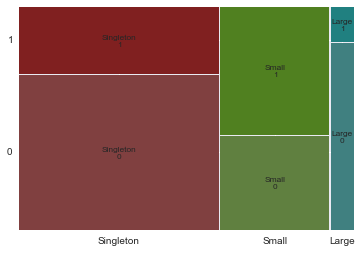

In [189]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(pd.crosstab(df.FamilySizeD, df.Survived).stack())

Mosica plot shows `Singleton` and `Large` families have survival penalty. While `Small` families dont.

## Effect of passenger's age on survival

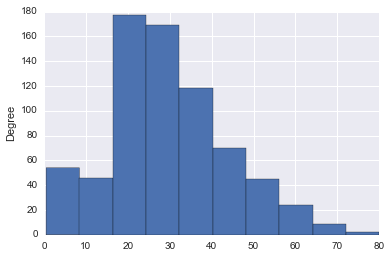

In [190]:
df.Age.plot(kind='hist')

In [191]:
df.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Most of the passengers are between 20 and 40, however `Age` is missing from many rows.

In [192]:
df.Age.isnull().value_counts(normalize=True)

False    0.801347
True     0.198653
dtype: float64

About ~20% of rows missing `Age` data. We are going to estimate `Age` for these rows. 
> Inspired by <https://www.kaggle.com/c/titanic/prospector#1294>

In [193]:
# describe Age by Pclass and Sex 
df.groupby(['Pclass','Sex'])['Age'].describe(percentiles=[.25,.5,.75,.95]).unstack()

count       mean        std   min     25%   50%    75%   95%  \
Pclass Sex                                                                    
1      female     85  34.611765  13.612052  2.00  23.000  35.0  44.00  58.0   
       male      101  41.281386  15.139570  0.92  30.000  40.0  51.00  65.0   
2      female     74  28.722973  12.872702  2.00  22.250  28.0  36.00  50.0   
       male       99  30.740707  14.793894  0.67  23.000  30.0  36.75  57.2   
3      female    102  21.750000  12.729964  0.75  14.125  21.5  29.75  44.9   
       male      253  26.507589  12.159514  0.42  20.000  25.0  33.00  47.0   

               max  
Pclass Sex          
1      female   63  
       male     80  
2      female   57  
       male     70  
3      female   63  
       male     74

* `Pclass` and `Sex` makes difference in `Age` distribution, We should consider these 2 factors while estimating missing Age of a passenger.
* We would like to use `Title` in the name to estimate `Age` too, that is if `Title` is `Master` we would like to estimate the `Age` by all the `Master` in the given data.

So lets create a new variable `Title` by parsing `Name`

In [194]:
df['Title'] = df.Name.str.split('[.,]').apply(lambda x:x[1].strip())
c = df.Title.value_counts(normalize=True)
rare_titles = c[c < 0.01].index.tolist() # rare title less than 1%
df[df.Title.isin(rare_titles)][['Age','Title','Sex']].sort(columns=['Title'])

,Age,Title,Sex
745,70,Capt,male
647,56,Col,male
694,60,Col,male
30,40,Don,male
317,54,Dr,male
660,50,Dr,male
398,23,Dr,male
766,NaN,Dr,male
245,44,Dr,male
632,32,Dr,male


Since list is small we can look at it manually and come up with mapping to normalize titles.

In [195]:
titles_mapping = {
    'Mr':['Capt','Col','Don','Jonkheer','Major','Rev','Sir'],
    'Miss':['Mlle','Mme','Ms','the Countess'],
    'Mrs':['Lady']
}
# make value -> key map
titles_mapping = dict([(v,k) for k,vals in titles_mapping.items() for v in vals])
       
df['TitleN'] = df['Title'].apply(lambda x: titles_mapping.get(x,x))

# 'Dr' is special as its for both male and female
df.loc[(df.Title=='Dr') & (df.Sex=='male'),'TitleN'] = 'Mr'
df.loc[(df.Title=='Dr') & (df.Sex=='female'),'TitleN'] = 'Mrs'

df.groupby(['TitleN','Title'])['Age'].describe().unstack()

count       mean        std    min     25%   50%    75%  \
TitleN Title                                                                   
Master Master           36   4.574167   3.619872   0.42   1.000   3.5   8.00   
Miss   Miss            146  21.773973  12.990292   0.75  14.125  21.0  30.00   
       Mlle              2  24.000000   0.000000  24.00  24.000  24.0  24.00   
       Mme               1  24.000000        NaN  24.00  24.000  24.0  24.00   
       Ms                1  28.000000        NaN  28.00  28.000  28.0  28.00   
       the Countess      1  33.000000        NaN  33.00  33.000  33.0  33.00   
Mr     Capt              1  70.000000        NaN  70.00  70.000  70.0  70.00   
       Col               2  58.000000   2.828427  56.00  57.000  58.0  59.00   
       Don               1  40.000000        NaN  40.00  40.000  40.0  40.00   
       Dr                5  40.600000  12.876335  23.00  32.000  44.0  50.00   
       Jonkheer          1  38.000000        NaN  38.00  38.000  38.0  38.00   
       Major             2  48.500000   4.949747  45.00  46.750  48.5  50.25   
       Mr              398  32.368090  12.708793  11.00  23.000  30.0  39.00   
       Rev               6  43.166667  13.136463  27.00  31.500  46.5  53.25   
       Sir               1  49.000000        NaN  49.00  49.000  49.0  49.00   
Mrs    Dr                1  49.000000        NaN  49.00  49.000  49.0  49.00   
       Lady              1  48.000000        NaN  48.00  48.000  48.0  48.00   
       Mrs             108  35.898148  11.433628  14.00  27.750  35.0  44.00   

                     max  
TitleN Title              
Master Master         12  
Miss   Miss           63  
       Mlle           24  
       Mme            24  
       Ms             28  
       the Countess   33  
Mr     Capt           70  
       Col            60  
       Don            40  
       Dr             54  
       Jonkheer       38  
       Major          52  
       Mr             80  
       Rev            57  
       Sir            49  
Mrs    Dr             49  
       Lady           48  
       Mrs            63

In [196]:
df.groupby('TitleN')['Age'].describe(percentiles=[.25,.5,.75,.95]).unstack()

,count,mean,std,min,25%,50%,75%,95%,max
TitleN,,,,,,,,,
Master,36,4.574167,3.619872,0.42,1.00,3.5,8.00,11.00,12
Miss,151,21.933775,12.817751,0.75,14.75,22.0,30.00,43.50,63
Mr,417,32.984412,12.988220,11.00,23.00,30.0,40.00,60.00,80
Mrs,110,36.127273,11.454024,14.00,28.00,35.0,44.75,55.55,63


TitleN
Master    Axes(0.125,0.125;0.775x0.775)
Miss      Axes(0.125,0.125;0.775x0.775)
Mr        Axes(0.125,0.125;0.775x0.775)
Mrs       Axes(0.125,0.125;0.775x0.775)
Name: Age, dtype: object

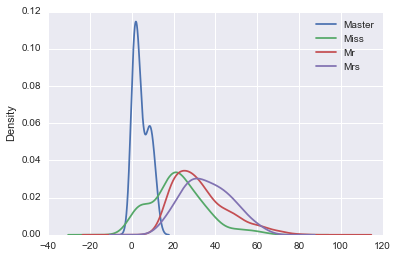

In [197]:
df.groupby('TitleN')['Age'].plot(kind='kde',legend=True)

We can look at by `Pclass` too

In [198]:
df.groupby(['TitleN','Pclass'])['Age'].describe().unstack()

count       mean        std    min    25%   50%    75%  max
TitleN Pclass                                                             
Master 1           3   5.306667   5.165475   0.92   2.46   4.0   7.50   11
       2           9   2.258889   2.342634   0.67   0.83   1.0   3.00    8
       3          24   5.350833   3.593608   0.42   2.00   4.0   9.00   12
Miss   1          49  29.693878  12.399940   2.00  22.00  30.0  36.00   63
       2          33  22.560606  13.200235   2.00  13.00  24.0  30.00   50
       3          69  16.123188   9.697315   0.75   9.00  18.0  22.00   45
Mr     1          98  42.382653  13.946104  17.00  31.00  42.0  51.00   80
       2          90  33.588889  12.258127  16.00  25.00  31.0  39.00   70
       3         229  28.724891  10.490946  11.00  21.00  26.0  34.00   74
Mrs    1          36  41.305556  12.404652  17.00  35.00  43.5  50.25   62
       2          41  33.682927  10.318525  14.00  26.00  32.0  41.00   57
       3          33  33.515152  10.031579  15.00  27.00  31.0  40.00   63

We will use `mean` by `TitleN` and `Pclass` to estimate age. Since `Pclass` is has effect on the mean Age.

In [199]:
# use mean by 'TitleN' and 'Pclass' as estimate for Age of that 'TitleN' and 'Pclass'

age_estimates = df.groupby(['TitleN','Pclass'])['Age'].describe().unstack()['mean'].round(1)

#print 'Age: before', df.Age.isnull().sum(), 'null values'

for title in df.TitleN.unique():
    for pclass in df.Pclass.unique():
        df.loc[(df.TitleN==title)&(df.Pclass==pclass)&(df.Age.isnull()),'Age'] = age_estimates[title][pclass]
    
#print 'Age: after', df.Age.isnull().sum(), 'null values'


### Now we will to see the effect of 'Age', 'Sex' and 'Pclass' on survival.

In [200]:
# first check any missing values
print 'Missing: Age %d, Sex %d, Pclass %d' % (df.Age.isnull().sum(), df.Sex.isnull().sum(), df.Pclass.isnull().sum())

Missing: Age 0, Sex 0, Pclass 0


In [201]:
# now we create bins of Age intervals
df['AgeBinned'] = pd.cut(df.Age, range(df.Age.min().astype(int),df.Age.max().astype(int)+1,15))

# create dataframe with %Survived
d = df.groupby(['Pclass','Sex','AgeBinned'])['Survived'].agg(['count','sum'])
d.columns = ['Total','Survived']
d['%Survived'] = (d['Survived']/d['Total']).round(2)
d['%Survived'].unstack()

AgeBinned      (0, 15]  (15, 30]  (30, 45]  (45, 60]  (60, 75]
Pclass Sex                                                    
1      female     0.67      0.97      1.00      0.94      1.00
       male       1.00      0.43      0.39      0.33      0.00
2      female     1.00      0.92      0.91      0.86       NaN
       male       1.00      0.02      0.15      0.00      0.33
3      female     0.53      0.52      0.41      0.00      1.00
       male       0.34      0.11      0.14      0.00      0.00

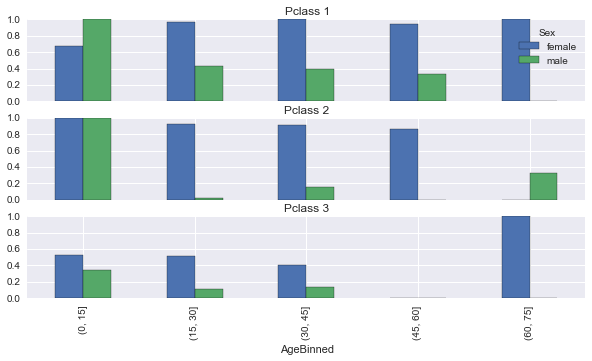

In [202]:
pclasses = d.index.get_level_values('Pclass').unique()
f, ax = plt.subplots(len(pclasses),1,figsize=(10, 5))
for i, pclass in enumerate(pclasses):
    d.xs(pclass,level='Pclass')['%Survived'].reset_index().pivot(
        index='AgeBinned',columns='Sex',values='%Survived').plot(
        kind='bar', ax=ax[i], sharex=True, legend=i==0,title='Pclass %s' % pclass)

Male in `Pclass` 3 between `Age` 15-45 had very less chances of survival.